# Inspecting gradients

This example assumes you've read `advanced.ipynb`, and covers:

   - Inspecting gradients per layer
   - Estimating good values of gradient clipping threshold

In [1]:
import os
import sys
from pathlib import Path
os.environ['TF_KERAS'] = '1'
os.environ['SCALEFIG'] = '.8'  # scale all drawn plots by 0.8
sys.path.insert(0, str(Path(Path.cwd()).parents[1]))
sys.path.insert(0, os.path.join(Path(Path.cwd()).parents[2], "see-rnn"))

import deeptrain
deeptrain.append_examples_dir_to_sys_path()
from utils import make_autoencoder, init_session
from utils import AE_CONFIGS as C

import numpy as np
from tensorflow.keras.optimizers import Adam

### Configure training

In [2]:
C['traingen']['iter_verbosity'] = 0  # silence iteration printing since currently irrelevant
tg = init_session(C, make_autoencoder)

Discovered 50 files with matching format
50 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated
Discovered 36 files with matching format
36 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated
NOTE: will exclude `labels` from saving when `input_as_labels=True`; to keep 'labels', add '{labels}'to `saveskip_list` instead
Preloading superbatch ... WARNING: multiple file extensions found in `path`; only .npy will be used 
Discovered 50 files with matching format
.................................................. finished, w/ 6400 total samples
Train initial data prepared
Preloading superbatch ... WARNING: multiple file extensions found in `path`; only .npy will be used 
Discovered 36 files with matching format
.................................... finished, w/ 4608 total sample

### Expected gradient norm estimation
We iterate over entire train dataset, gathering gradients from every fit and computing and storing their L2-norms.

Computing gradient l2-norm over datagen batches, in inference mode
'.' = slice processed, '|' = batch processed

Data set_nums shuffled

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50
Data set_nums shuffled


GRADIENT L2-NORM (AVG, MAX) = (0.001, 0.001), computed over 50 batches, 50 datagen updates


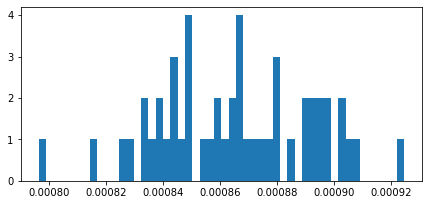

In [3]:
grad_norms, *_ = tg.gradient_norm_over_dataset()

We can now restart training with setting optimizer `clipnorm` to 1.5x average value, avoiding extreme gradients while not clipping most standard gradients

Discovered 50 files with matching format
50 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated
Discovered 36 files with matching format
36 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated
NOTE: will exclude `labels` from saving when `input_as_labels=True`; to keep 'labels', add '{labels}'to `saveskip_list` instead
Preloading superbatch ... WARNING: multiple file extensions found in `path`; only .npy will be used 
Discovered 50 files with matching format
.................................................. finished, w/ 6400 total samples
Train initial data prepared
Preloading superbatch ... WARNING: multiple file extensions found in `path`; only .npy will be used 
Discovered 36 files with matching format
.................................... finished, w/ 4608 total sample

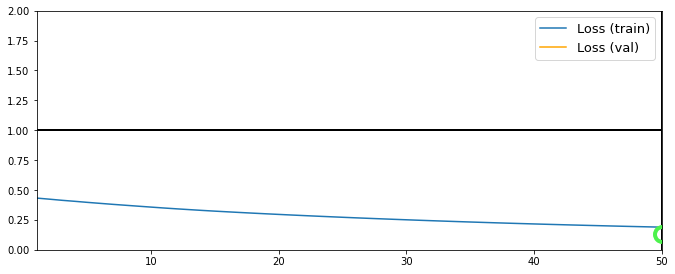

Training has concluded.


In [4]:
C['model']['optimizer'] = Adam(clipnorm=1.5 * np.mean(grad_norms))
tg = init_session(C, make_autoencoder)
tg.epochs = 1  # train just for demo
tg.train()

### Complete gradient sum
This time we run a cumulative sum over actual gradient tensors, preserving and returning their shapes, allowing per-weight visualization

Computing gradients sum over datagen batches, in inference mode
'.' = slice processed, '|' = batch processed

Data set_nums shuffled

||||||||||10||||||||||20||||||||||30||||||||||40||||||||||50
Data set_nums shuffled


GRADIENTS SUM computed over 50 batches, 50 datagen updates:


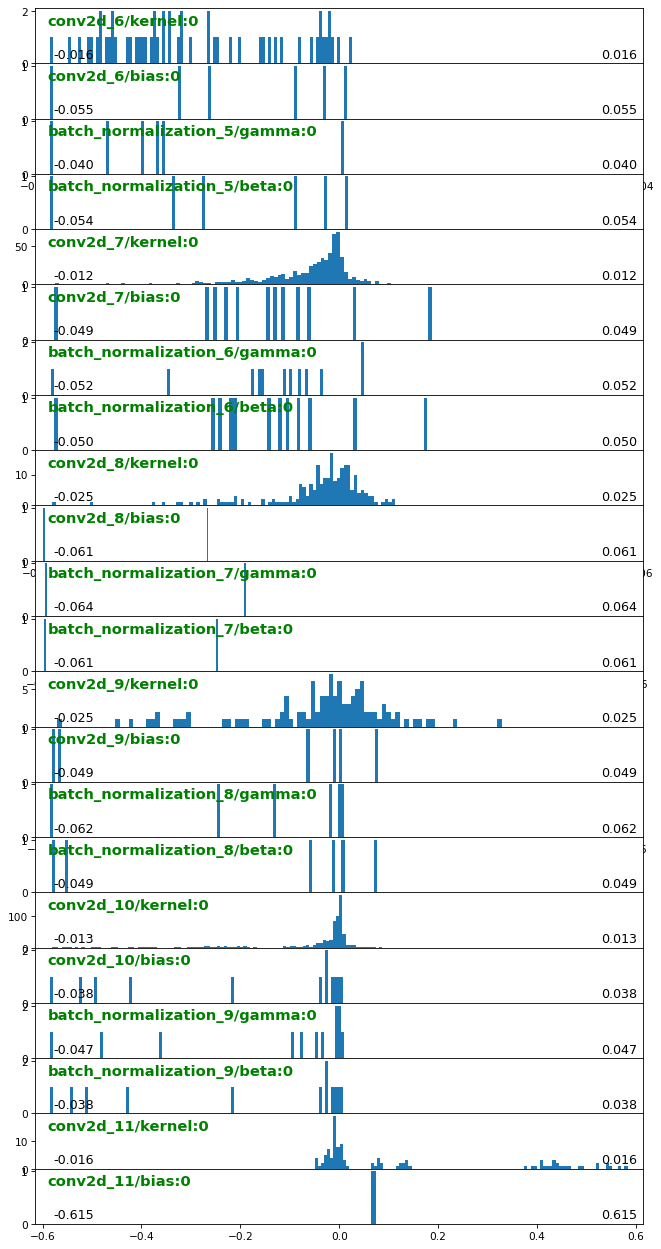

In [5]:
plot_kw = {'h': 2}  # double default height since we expect many weights
grads_sum, *_ = tg.gradient_sum_over_dataset(plot_kw=plot_kw)

We can use the mean of `grads_sum` to set `clipvalue` instead of `clipnorm`.